# TKT4108 Structural dynamics 2

## Solution Exercise 6

**Main topics:** Signal processing and system identification

**References:** Jupyter notebook examples 

**Hint**: Take a look at the examples posted on Github

### Problem 1

<img src="Fig_6_1.svg">

In this problem we will consider the same share frame as in problem set 5. Use the code below to obtain accelaration time series:

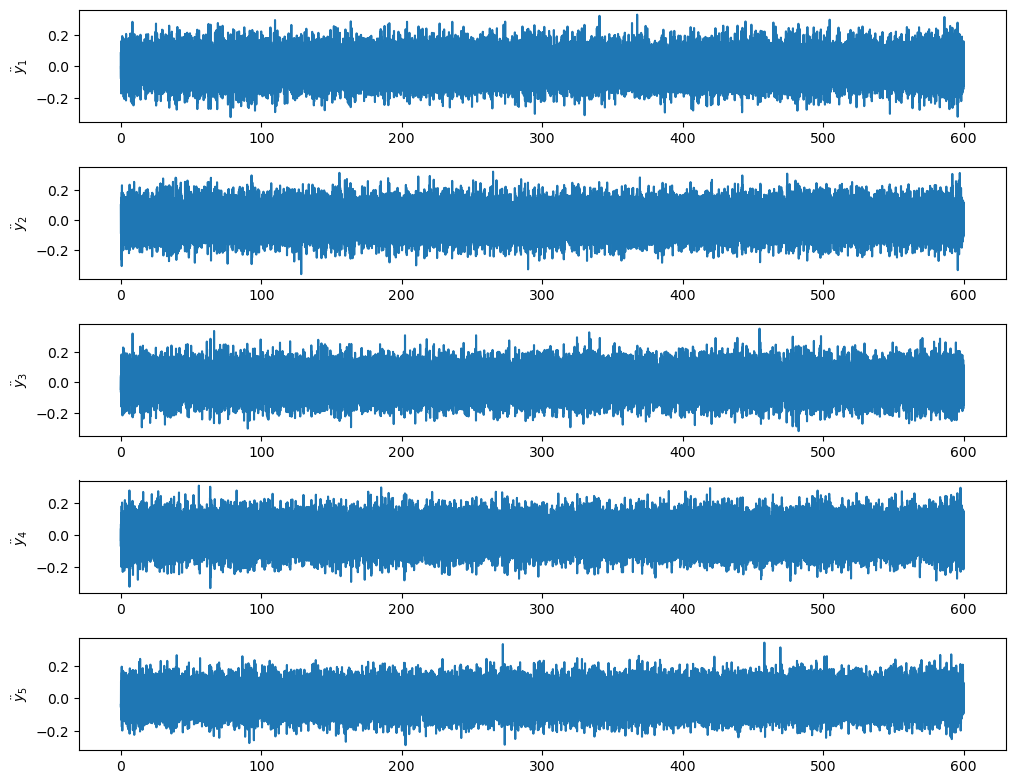

In [14]:
import numpy as np
from scipy import linalg as spla


from time_integration import *
from matplotlib import pyplot as plt
from scipy import signal as spsi

MM = np.eye(5) *1000
KK = np.zeros((6,6))
EI = 2.1e11*3.34e-6
L = 3
ks = 2 *12*EI/L**3

for k in range(5):
    KK[k+1,k+1] = KK[k+1,k+1] + ks
    KK[k,k] = KK[k,k] + ks
    KK[k+1,k] = KK[k+1,k] -ks
    KK[k,k+1] = KK[k,k+1] -ks

KK = KK[1::,1::] # Introduce boundary conditions

lam, vec = spla.eig(KK,MM)

indx = np.argsort(lam)
lam = lam[indx]


vec = vec[:,indx]

f = np.real(lam**0.5)/2/np.pi

MM_modal = vec.T @ MM @ vec

CC_modal = 2*np.eye(5)*5/100*MM_modal*np.diag(f)*2*np.pi

CC = vec @ CC_modal @ vec.T

t = np.arange(0,600,0.01)

x=np.random.normal(0,50, size=(5,len(t))) # White noise loading

u0 = np.zeros((5,1))
udot0 = np.zeros((5,1))

gamma = 1/2
beta = 1/4

h = t[1] - t[0]

y, _, y2dot = linear_newmark_krenk(MM,CC,KK,x,u0,udot0,h,gamma,beta)

fix, axs = plt.subplots(5,1,figsize=(10,8))

plt.tight_layout()

for k in range(5):
    axs[k].plot(t,y2dot[k,:])
    axs[k].set_ylabel("$\ddot{y}_" + str(k+1) + "$")


a) Solve the eigenproblem and obtain undamped natural frequencies and modes

#### Solution

In [15]:
lam, v = spla.eig(KK,MM)
arg = np.argsort(lam)
lam = lam[arg]
v = v[:,arg]

f_n = np.real(lam**0.5)/2/np.pi
print(f_n*2*np.pi)

# Normalize modes such that largest value is 1
for k in range(v.shape[0]):
    v[:,k] = v[:,k] / np.max(np.abs(v[:,k]))

[ 7.10700791 20.74525622 32.70284724 42.01104807 47.91576364]


b) Use simulated time series to identify frequencies and modes using the basic frequency domain method (peak picking)

#### Solution

The first step is to estimate the cross-spectral density of the response. We have used Welche's method in this solution since it provides a smooth estimate of the auto-spectral and cross-spectral densities.

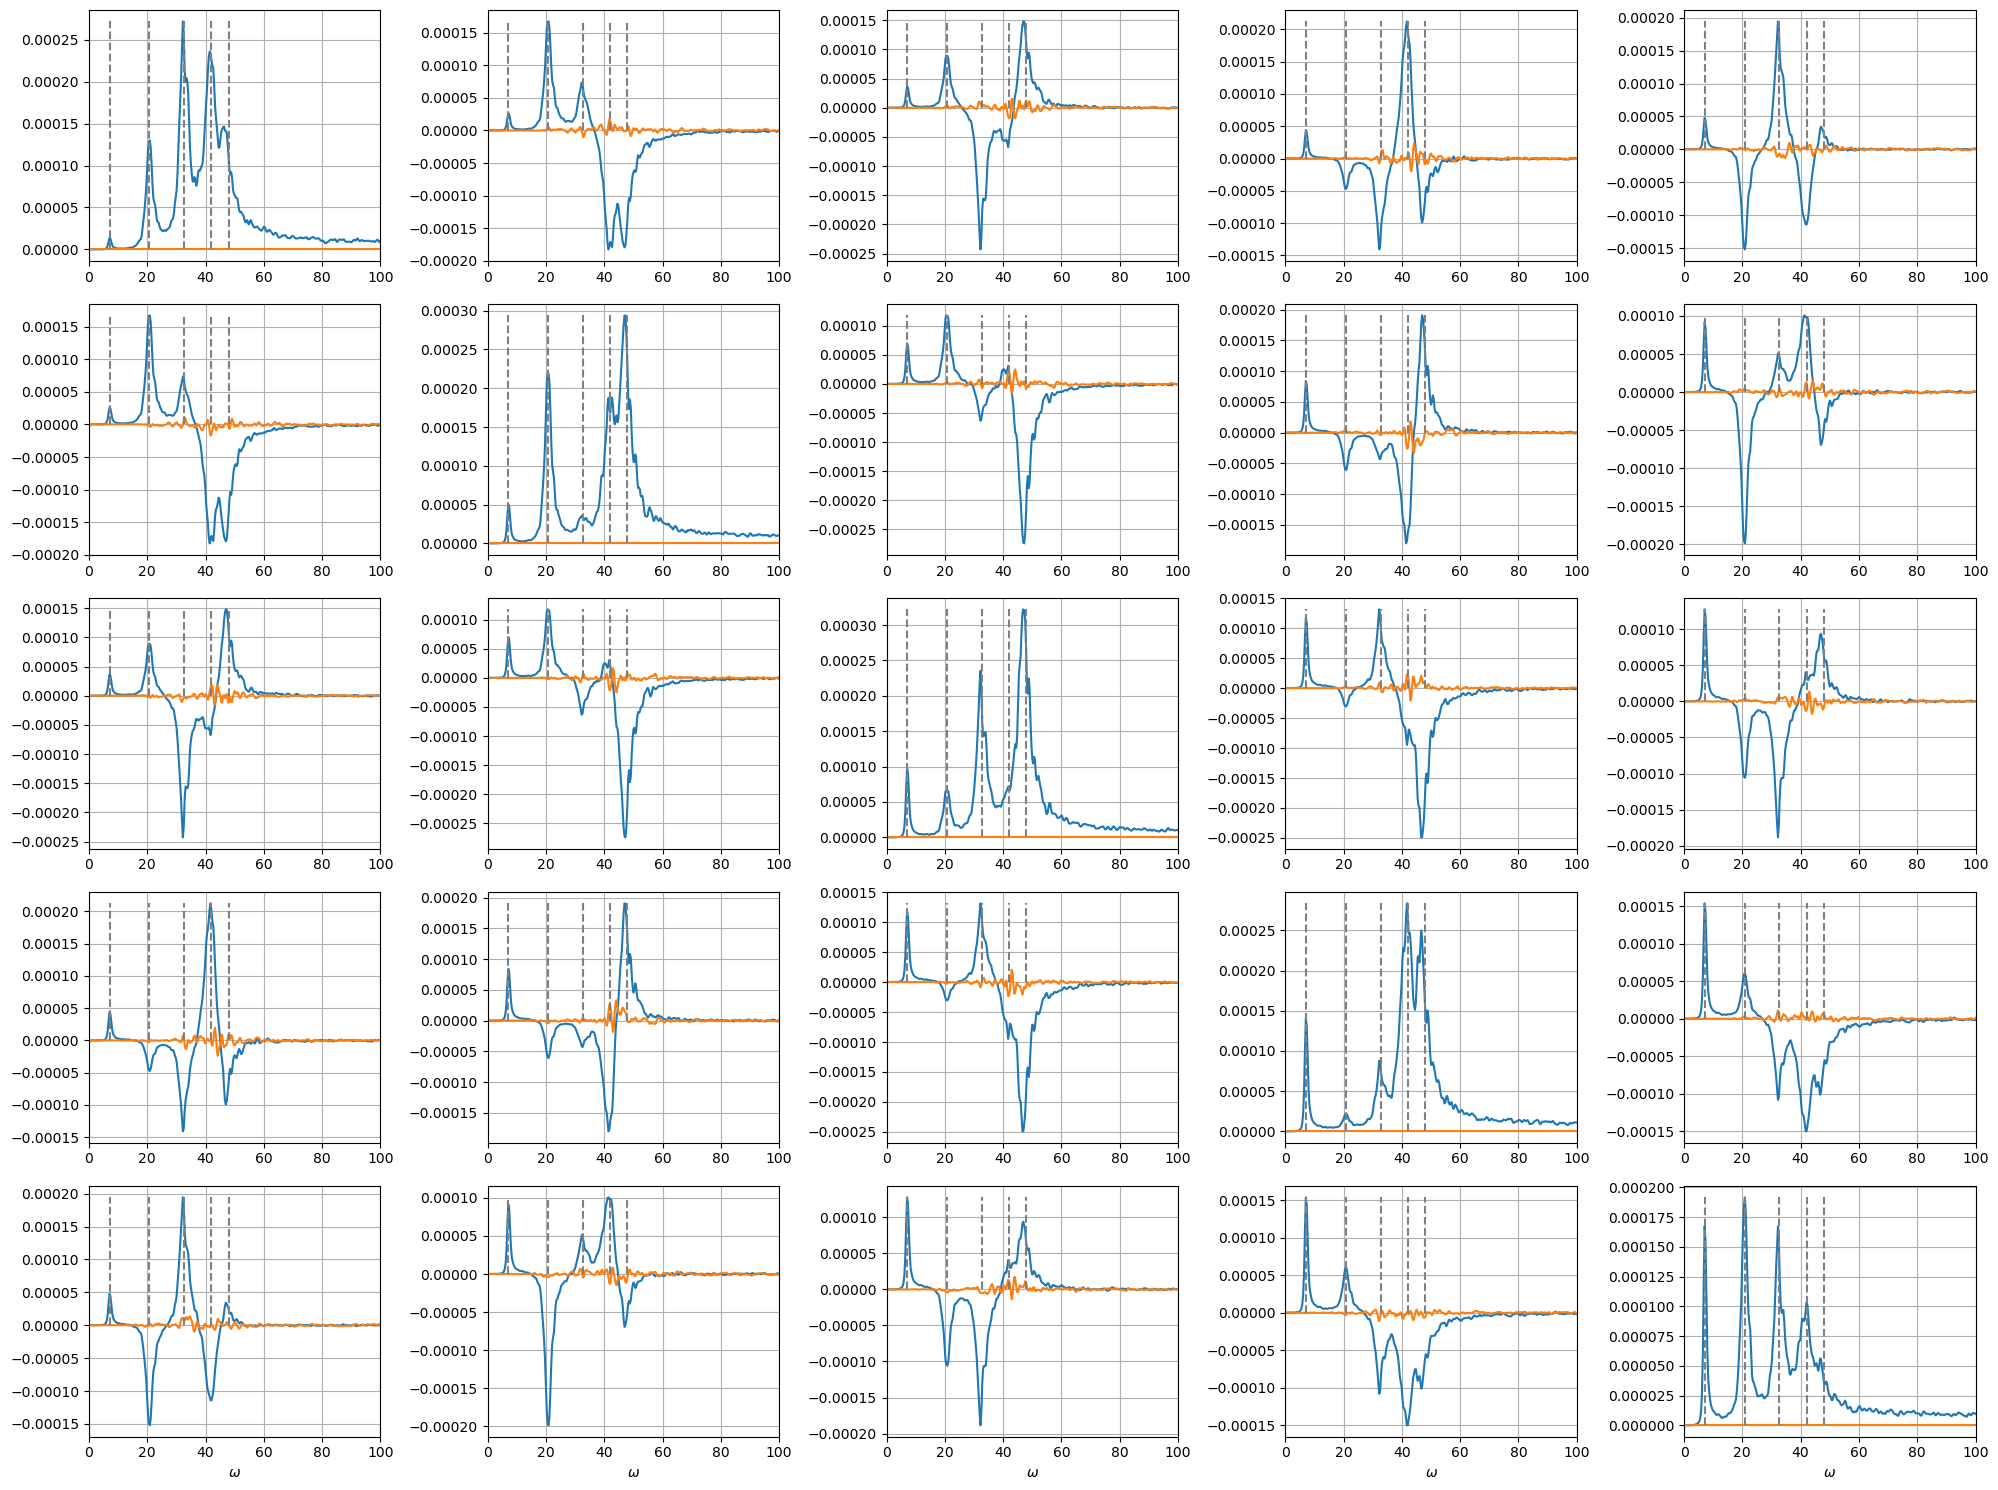

In [16]:
dt = t[2]-t[1]

npoints_window = np.ceil(len(t)/50)
nfft_pow2 = 2**(np.ceil(np.log2(npoints_window))) # Next power of 2, to make the FFT more efficient

S_welch = np.zeros((y2dot.shape[0],y2dot.shape[0],int(nfft_pow2/2+1)),dtype=complex) #initialize the cross-spectral density matrix of the response
for k1 in range(y2dot.shape[0]):
    for k2 in range(y2dot.shape[0]):
        f, S_Hz = spsi.csd(y2dot[k1,:],y2dot[k2,:], fs=1/dt, window='hann', nperseg=npoints_window, nfft=nfft_pow2 , detrend='constant')
        
        w_welch = f*2*np.pi # Frequency axis in rad/s
        S_welch[k1,k2,:] = S_Hz/(2*np.pi) # Spectrum in rad/s
        
fig, axs = plt.subplots(y2dot.shape[0],y2dot.shape[0], figsize=(20,15))

for k1 in range(y2dot.shape[0]):
    for k2 in range(y2dot.shape[0]):
        axs[k1,k2].plot(w_welch,np.real(S_welch[k1,k2,:]))
        axs[k1,k2].plot(w_welch,np.imag(S_welch[k1,k2,:]))
        
        axs[k1,k2].set_xlim(0,100)
        axs[k1,k2].grid(True)
        axs[k1,k2].vlines(f_n*2*np.pi,np.zeros(len(f_n)),np.ones(len(f_n))*np.max(np.real(S_welch[k1,k2,:])),colors="grey",linestyles="dashed")

for k2 in range(y2dot.shape[0]):
    axs[k1,k2].set_xlabel("$\omega$")

plt.tight_layout()

From the auto- and cross-spectral densities, we can quickly identify four peaks, one less peak than the degrees of freedom in the model. We can also spot the fifth peak if we look carefully, and the vertical lines corresponding to the natural frequencies obtained in problem a are helpful. Knowing the natural frequencies beforehand is impossible for actual structures, so one must rely on the clear peaks in an actual situation. 


It is often the case that not all the structure's natural frequencies show up in the auto- and cross-spectral densities. This occurs if some vibration modes are not excited by the loads acting on the structure. Another possible reason is if some of the natural frequencies are closely spaced such that the two peaks appear as one broader peak in the auto- and cross-spectral densities. Therefore, it is crucial to test different window lengths and assess the optimal size of the window for the particular case considered. Using too many windows may result in over-smoothing, and some of the peaks disappear.

It is common to take the sum of the auto-spectral densities and pick the peaks. If the auto-spectral densities have different magnitudes, it is possible to use a weighted sum to make it easier to identify the peaks. Here the auto-spectral densities are of similar magnitude, and we can thus disregard weighting.


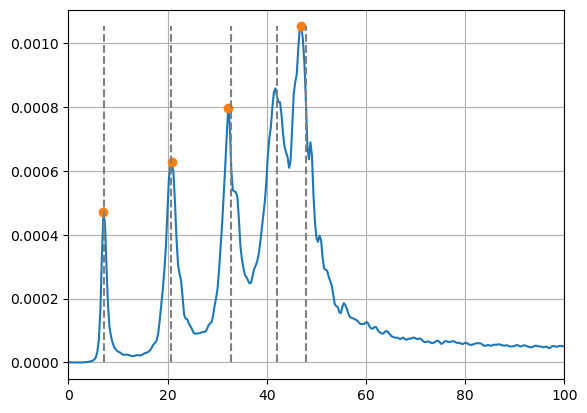

In [17]:
S = S_welch[0,0,:] +  S_welch[1,1,:] +  S_welch[2,2,:] +  S_welch[3,3,:] +  S_welch[4,4,:]

peaks_index,_ = spsi.find_peaks(np.abs(S), distance=20, height=0.3*np.max(np.abs(S))) 
plt.figure()
plt.plot(w_welch,np.real(S))
plt.plot(w_welch[peaks_index],np.real(S[peaks_index]),"o")
plt.vlines(f_n*2*np.pi,np.zeros(len(f_n)),np.ones(len(f_n))*np.max(np.real(S)),colors="grey",linestyles="dashed")

plt.xlim(0,100)
plt.grid()

As can be seen, the identified peaks correspond very well to the actual natural frequencies of the system (the grey dashed lines). The next step is to obtain the vibration modes from the auto- and cross-spectral densities. It is assumed that only one mode contributes to the response at the peaks in the spectral densities. This implies that the following expression can approximate the auto-spectral density in the degree of freedom k.

$$S_{yk}(\omega_n) = v_{nk} S_{\eta}(\omega_n) v_{rk} = v_{nk}^2 S_{\eta}(\omega_n) $$

The modes are then found by first setting a reference value for one of the degrees of freedom, and the rest are found by the ratio of the value of the auto-spectral densities at the considered natural frequency. The sign of the mode shape value is taken from the real part of the cross-spectral density. A positive real part means that the points move in the same direction, while a negative sign implies that the correlation is negative and that the points move in opposite directions. The following python script obtains the vibration modes. The results are compared to the actual modes of the structure in the figure below.

C:\Users\oyvinpet\AppData\Local\Temp\ipykernel_27320\183844027.py:10: RuntimeWarning: invalid value encountered in divide
  modes[:,k] = modes[:,k] / np.max(np.abs(modes[:,k]))


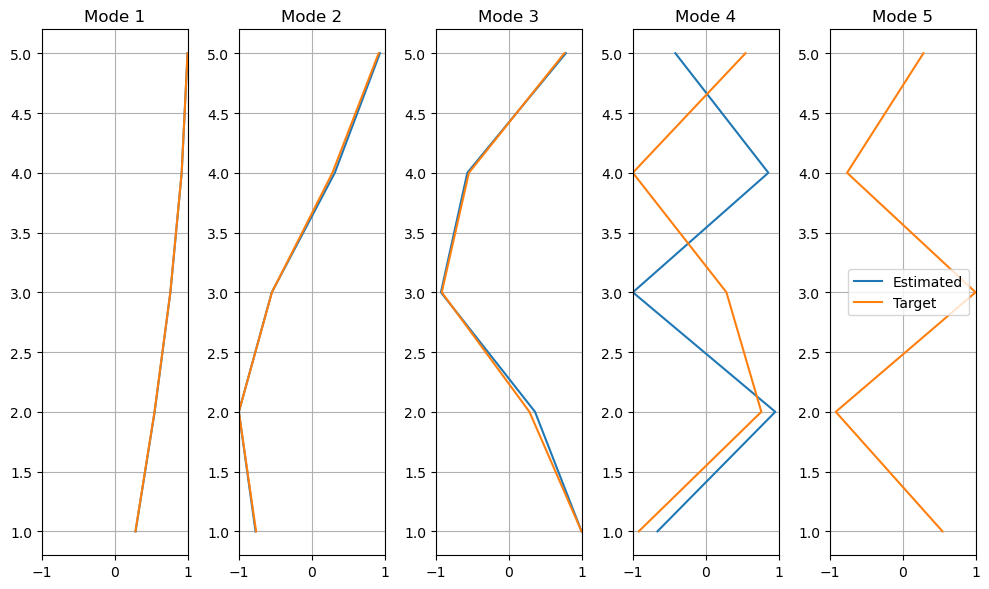

In [18]:
# Estimate the mode shapes from the cross-spectral density matrix of the response
modes = np.zeros((S_welch.shape[0],S_welch.shape[0]))
for k in range(peaks_index.shape[0]):
    modes[0,k] = 1.0
    for n in range(1,S_welch.shape[0]):
        modes[n,k] = np.real(S_welch[n,n,peaks_index[k]]/S_welch[0,0,peaks_index[k]])**0.5*np.sign(np.real(S_welch[0,n,peaks_index[k]]))   
        
# Normalize modes such that largest value is 1
for k in range(modes.shape[0]):
    modes[:,k] = modes[:,k] / np.max(np.abs(modes[:,k]))

# Change the sign of the modes to compare with target values
modes[:,1] = modes[:,1]*-1
modes[:,3] = modes[:,3]*-1

# Plot modes and compare to target values
fig, axs = plt.subplots(1,5,figsize=(10,6))

for k in range(modes.shape[1]):
    axs[k].plot(modes[:,k],np.arange(1,6),label="Estimated")
    axs[k].plot(v[:,k],np.arange(1,6),label="Target")
    axs[k].set_title("Mode " + str(k+1))
    axs[k].grid(True)
    axs[k].set_xlim(-1,1)

axs[k].legend()
plt.tight_layout()
    
        

The vibration modes estimated from the time series correspond to the actual vibration modes excellently. In a real situation where measurement noise is present and the excitation of the structure is weaker, we need to expect more significant discrepancies from the actual modes. The results illustrate, however, that we have implemented the basic frequency domain method correctly.

c) Use simulated time series to identify frequencies and modes using frequency domain decomposition (FDD)

#### Solution
The starting point of frequency domain decomposition is to estimate the cross-spectral density matrix of the response. The cross-spectral density matrix is then factorized using the singular value decomposition.

$$\mathbf{S_y}(\omega)=\mathbf{U}(\omega) \mathbf{\Sigma}(\omega) \mathbf{V}(\omega)^\text{H}$$

Here $\mathbf{U}(\omega)$ and $\mathbf{V}(\omega)^H$ represents the left and right singular vectors while the diagonal matrix $\mathbf{\Sigma}(\omega)$ contains the singular values. Similar to the basic frequency domain method, we now assume that only one mode contributes to the response at the natural frequencies of the system. Sometimes, two or more modes can have the same natural frequency. In such cases, two or more singular values are significant, and we can identify all modes by considering all significant singular values and corresponding vectors. In most cases, the structure has natural frequencies that are different. This implies that only the largest singular value and the corresponding left and right singular vectors are important. The relation between the cross-spectral density matrix in modal coordinates and the one in physical dofs can be written as shown below

$$ \mathbf{S}_y(\omega)= \mathbf{\Phi}\mathbf{S}_{\eta}(\omega) \mathbf{\Phi}^\text{H}$$

Here $\mathbf{\Phi}$ is the vibration modes of the structure, and $\mathbf{S}_{\eta}(\omega)$ is the cross-spectral density matrix of the response in normal (modal) coordinates. Comparing the two expressions, we see that the singular vectors corresponding to the largest singular values can be used to approximate the modes. The code for the FDD is shown below. Keep in mind that we can use the estimate of the response-cross spectral density from problem a

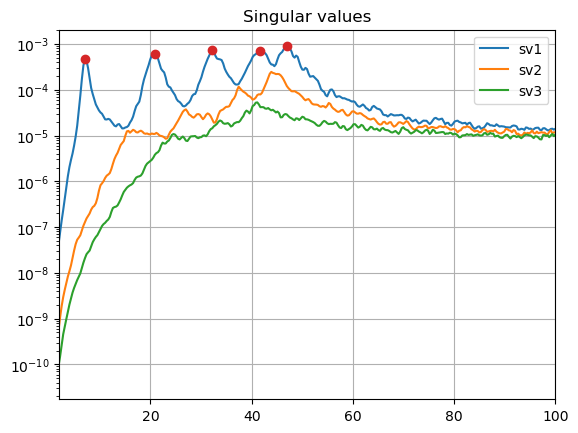

In [21]:
singular_values = np.zeros((3,len(w_welch)))
first_left_singular_vectors = np.zeros((5,len(w_welch)),dtype=complex)

for k in range(len(w_welch)):
    
    us, sigma, vs = spla.svd(S_welch[:,:,k])
    
    singular_values[:,k] = sigma[0:3]
    first_left_singular_vectors[:,k] = us[:,0]
    
peaks_index,_ = spsi.find_peaks(singular_values[0,:], distance=15, height=0.25*np.max(singular_values[0,:])) 
    
plt.figure()
plt.plot(w_welch,singular_values[0,:],label="sv1")
plt.plot(w_welch,singular_values[1,:],label="sv2")
plt.plot(w_welch,singular_values[2,:],label="sv3")
plt.plot(w_welch[peaks_index],singular_values[0,peaks_index],"o")
plt.yscale("log")
plt.xlim(2,100)
plt.grid()
plt.legend()
plt.title("Singular values");


        

The plots of the singular values illustrate that we can model most of the cross-spectral density matrix of the response by the first singular values and the corresponding vectors. The first singular value, in particular, dominates the contribution to the auto-and cross-spectral densities at the peaks. We can now plot the modes by considering the singular vectors corresponding to the largest singular value at the peaks in the singular value plot above.

Note that picking the peaks in the singular value plot can be tricky. It can to some extent be automated by tuning the 
*distance* and *height* arguments in the *find_peaks* function. It is also possible to manually pick the frequencies.

In [24]:
# Pick the modes from the singular vectors
modes_fdd = np.zeros((5,5),dtype=complex)
for k in range(peaks_index.shape[0]):
    modes_fdd[:,k] = first_left_singular_vectors[:,peaks_index[k]]
    modes_fdd[:,k] = modes_fdd[:,k]/np.max(np.real(modes_fdd[:,k]))

# Change singn to make comparison easier
modes_fdd[:,2] = modes_fdd[:,2]*-1
modes_fdd[:,4] = modes_fdd[:,4]*-1

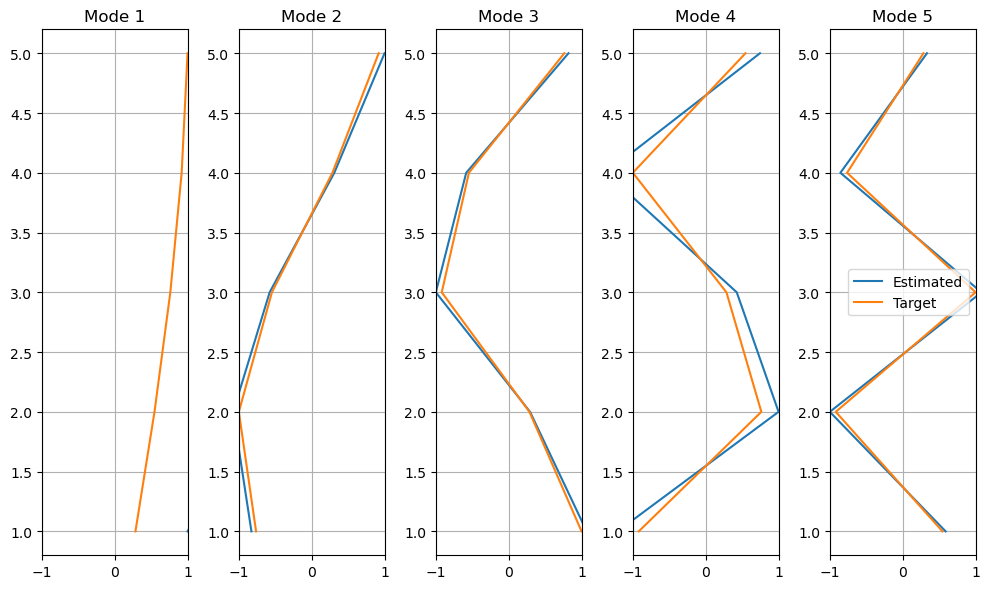

In [23]:

# Plot modes and compare to target values
fig, axs = plt.subplots(1,5,figsize=(10,6))

for k in range(modes.shape[1]):
    axs[k].plot(np.real(modes_fdd[:,k]),np.arange(1,6),label="Estimated")
    axs[k].plot(v[:,k],np.arange(1,6),label="Target")
    axs[k].set_title("Mode " + str(k+1))
    axs[k].grid(True)
    axs[k].set_xlim(-1,1)

axs[k].legend()
plt.tight_layout()

The figures above shows that the estimated modes corresponds very well to the targets.